In [375]:
##Lets webscrap Toronto housing! 

In [2]:
from bs4 import BeautifulSoup # For HTML parsing
import requests # Website connections
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
import pandas as pd # For converting results to a dataframe and bar chart plots
import json # For parsing json
from requests import get
from random import randint
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

In [3]:
#get the first page of the Toronto housing prices
response = get('https://toronto.craigslist.org/search/apa?hasPic=1&availabilityMode=0&sale_date=all+dates')
#delete  post of an housing option without a pic using their filter

In [4]:
print(response.text[:500])

﻿<!DOCTYPE html>
<html class="no-js"><head>
    <title>toronto apts/housing for rent  - craigslist</title>

    <meta name="description" content="toronto apts/housing for rent  - craigslist">
    <meta http-equiv="X-UA-Compatible" content="IE=Edge"/>
    <link rel="canonical" href="https://toronto.craigslist.org/search/apa">
    <link rel="alternate" type="application/rss+xml" href="https://toronto.craigslist.org/search/apa?availabilityMode=0&amp;format=rss&amp;hasPic=1" title="RSS feed for crai


In [5]:
html_soup = BeautifulSoup(response.text, 'html.parser')

In [6]:
type(html_soup)

bs4.BeautifulSoup

In [7]:
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 50 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [8]:
#The first post on craiglist
post_one = posts[0]
post_one

<li class="result-row" data-pid="6980917396">
<a class="result-image gallery" data-ids="1:00t0t_d2VSAo28vkk,1:00D0D_eec2dzn6uQo,1:00M0M_7VLZDMo3L4F,1:00505_fjS5lcBPoWZ,1:00202_2Mz1MEwY65Q,1:00U0U_4HYM5ZKM5bf" href="https://toronto.craigslist.org/tor/apa/d/north-york-house-for-lease/6980917396.html">
<span class="result-price">$4800</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2019-09-17 18:24" title="Tue 17 Sep 06:24:05 PM">Sep 17</time>
<a class="result-title hdrlnk" data-id="6980917396" href="https://toronto.craigslist.org/tor/apa/d/north-york-house-for-lease/6980917396.html">house for lease</a>
<span class="result-meta">
<span class="result-price">$4800</span>
<span class="housing">
                    3br -
                    2500ft<sup>2</sup> -
                </span>
<span class="result-hood"> (toronto)</span>
<span class="result-tags">
<span

In [9]:
#grab the price of the first post
post_one_price = post_one.a.text
post_one_price

'\n$4800\n'

In [10]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

#split them and grab each element of the resulting list to get date and time
post_one_datetime = post_one_datetime.split(' ')
post_one_date = post_one_datetime[0]
post_one_date

#element 2 is the time
post_one_time = post_one_datetime[1]

post_one_time

'18:24'

In [11]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']
post_one_link

'https://toronto.craigslist.org/tor/apa/d/north-york-house-for-lease/6980917396.html'

In [12]:
#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text
post_one_title_text

'house for lease'

In [13]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = post_one.find('span', class_= 'result-hood').text
post_one_hood

' (toronto)'

In [14]:
#getting sqft
post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3]
post_one_sqft


'2500'

In [16]:
#Lets do the loop now
#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)

pages = np.arange(0, results_total, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
post_links = []
post_prices = []
sqfts = []
bedroom_counts = []
for page in pages:
    
    #get request
    response = get("https://toronto.craigslist.org/search/eby/apa?" 
                   + "s=" 
                   + str(page) 
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span',class_ = 'result-price') is None:
                post_price = np.nan
            else:
                post_price = post.a.text.strip().replace("\n$", "")
                post_prices.append(post_price)
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
                


    iterations += 1
    print("Finished iteration: " + str(iterations))

Finished iteration: 1
Finished iteration: 2
Finished iteration: 3
Finished iteration: 4
Finished iteration: 5
Finished iteration: 6
Finished iteration: 7
Finished iteration: 8
Finished iteration: 9
Finished iteration: 10
Finished iteration: 11
Finished iteration: 12
Finished iteration: 13
Finished iteration: 14
Finished iteration: 15
Finished iteration: 16
Finished iteration: 17
Finished iteration: 18
Finished iteration: 19
Finished iteration: 20
Finished iteration: 21
Finished iteration: 22
Finished iteration: 23
Finished iteration: 24
Finished iteration: 25


In [17]:
import pandas as pd

to_rooms = pd.DataFrame({'Date_Posted': post_timing,
                       'Neighborhood': post_hoods,
                       'Post_Title': post_title_texts,
                       'URL': post_links,
                       'Price': post_prices,
                       'Sqft':sqfts,
                        'Bedrooms':bedroom_counts})

In [18]:
to_rooms['Post_Title'].unique().shape

(113,)

In [19]:
to_rooms['Price']=to_rooms['Price'].str.replace('$','')
to_rooms['Neighborhood']=to_rooms['Neighborhood'].str.replace('(','')
to_rooms['Neighborhood']=to_rooms['Neighborhood'].str.replace(')','')
to_rooms['Bedrooms'] = to_rooms['Bedrooms'].apply(lambda x: float(x))
print(to_rooms.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2850 entries, 0 to 2849
Data columns (total 7 columns):
Date_Posted     2850 non-null object
Neighborhood    2850 non-null object
Post_Title      2850 non-null object
URL             2850 non-null object
Price           2850 non-null object
Sqft            1900 non-null float64
Bedrooms        2700 non-null float64
dtypes: float64(2), object(5)
memory usage: 155.9+ KB
None


In [20]:
to_rooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2850 entries, 0 to 2849
Data columns (total 7 columns):
Date_Posted     2850 non-null object
Neighborhood    2850 non-null object
Post_Title      2850 non-null object
URL             2850 non-null object
Price           2850 non-null object
Sqft            1900 non-null float64
Bedrooms        2700 non-null float64
dtypes: float64(2), object(5)
memory usage: 155.9+ KB


In [21]:
to_rooms['Date_Posted'] = pd.to_datetime(to_rooms['Date_Posted'])

In [22]:
to_rooms['Price'] = to_rooms['Price'].astype(str)

In [23]:
import re

to_rooms['Price'] = to_rooms['Price'].apply(lambda x: re.sub(r'[\n$]+', '', x))

#replace '' with NaN values in the df before turning the column to int so data shape is maintained

In [24]:
import numpy as np
to_rooms['Price'].replace('', np.nan, inplace=True)

In [25]:
#drop the NAs because we dont like na
to_rooms = to_rooms.dropna()

In [26]:
to_rooms.info() #we still need to change the price to an int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850 entries, 0 to 2849
Data columns (total 7 columns):
Date_Posted     1850 non-null datetime64[ns]
Neighborhood    1850 non-null object
Post_Title      1850 non-null object
URL             1850 non-null object
Price           1850 non-null object
Sqft            1850 non-null float64
Bedrooms        1850 non-null float64
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 115.6+ KB


In [27]:
#now turn the price to int as well
to_rooms['Price'] = to_rooms['Price'].astype(int)

In [28]:
to_rooms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850 entries, 0 to 2849
Data columns (total 7 columns):
Date_Posted     1850 non-null datetime64[ns]
Neighborhood    1850 non-null object
Post_Title      1850 non-null object
URL             1850 non-null object
Price           1850 non-null int64
Sqft            1850 non-null float64
Bedrooms        1850 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 115.6+ KB


In [29]:
to_rooms.describe()

,Price,Sqft,Bedrooms
count,1850.000000,1850.000000,1850.000000
mean,3409.810811,948.310811,1.527027
std,1667.596533,515.650438,0.775207
min,1350.000000,400.000000,1.000000
25%,2495.000000,650.000000,1.000000
50%,2995.000000,750.000000,1.000000
75%,3850.000000,1150.000000,2.000000
max,12000.000000,3400.000000,5.000000


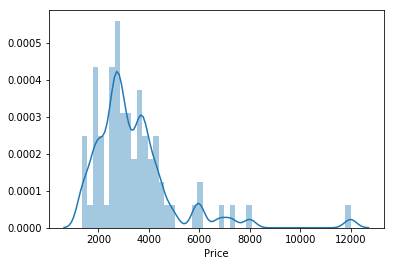

In [30]:
#start to look at the distributions
from matplotlib import figure
import matplotlib as plt
import seaborn as sns
%matplotlib inline

sns.distplot(to_rooms['Price']);

In [31]:
to_rooms.head(200)

,Date_Posted,Neighborhood,Post_Title,URL,Price,Sqft,Bedrooms
0,2019-09-17 18:24:00,toronto,house for lease,https://toronto.craigslist.org/tor/apa/d/north...,4800,2500.0,3.0
1,2019-09-17 18:10:00,Danforth East @ Main St,One Bedroom Condo (+ Den) for Rent on the Danf...,https://toronto.craigslist.org/tor/apa/d/toron...,1900,618.0,1.0
3,2019-09-17 18:03:00,Etobicoke,Fully Furnished 1bd + 1 den short term rental ...,https://toronto.craigslist.org/tor/apa/d/etobi...,2650,675.0,1.0
4,2019-09-17 17:47:00,50 Lombard St,Newly Renovated South Facing Condo Unit @ Lomb...,https://toronto.craigslist.org/tor/apa/d/toron...,2750,750.0,1.0
5,2019-09-17 17:44:00,Scarborough,3 Level 2 Bedroom 3 Bathroom Home with Large P...,https://toronto.craigslist.org/tor/apa/d/scarb...,2995,1700.0,2.0
6,2019-09-17 17:43:00,Fashion District,Beautiful 1 Bedroom Suite with South Facing Vi...,https://toronto.craigslist.org/tor/apa/d/toron...,3195,700.0,1.0
7,2019-09-17 17:36:00,West Woodbridge Vaughan,2 bdrm Penthouse unit Market Lane Area Of Wood...,https://toronto.craigslist.org/yrk/apa/d/woodb...,1350,1179.0,2.0
8,2019-09-17 17:33:00,THE ANNEX,Contemporary 1 Bedroom with 1 Bathroom plus Mo...,https://toronto.craigslist.org/tor/apa/d/toron...,2495,650.0,1.0
9,2019-09-17 17:32:00,Yorkville,Stunning 2 Bedroom 2 bathroom Suite with Hardw...,https://toronto.craigslist.org/tor/apa/d/toron...,7260,1200.0,2.0
10,2019-09-17 17:31:00,Distillery District,"Sophisticated 1 Bedroom, 1 Bath with Large Bal...",https://toronto.craigslist.org/tor/apa/d/toron...,3650,524.0,1.0


In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


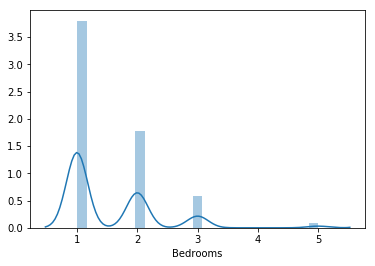

In [33]:
sns.distplot(to_rooms['Bedrooms'])

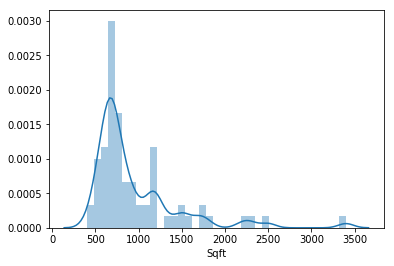

In [34]:
sns.distplot(to_rooms['Sqft'])

In [35]:
#Before applying the command I have 625 rows
#Lets drop the drop the duplicate with the same title
to_rooms = to_rooms.drop_duplicates(subset='Post_Title') 


In [36]:
print(to_rooms)

            Date_Posted                              Neighborhood  \
0   2019-09-17 18:24:00                                   toronto   
1   2019-09-17 18:10:00                   Danforth East @ Main St   
3   2019-09-17 18:03:00                                 Etobicoke   
4   2019-09-17 17:47:00                             50 Lombard St   
5   2019-09-17 17:44:00                               Scarborough   
6   2019-09-17 17:43:00                          Fashion District   
7   2019-09-17 17:36:00                   West Woodbridge Vaughan   
8   2019-09-17 17:33:00                                 THE ANNEX   
9   2019-09-17 17:32:00                                 Yorkville   
10  2019-09-17 17:31:00                       Distillery District   
11  2019-09-17 17:30:00                    Entertainment District   
12  2019-09-17 17:29:00                               Scarborough   
13  2019-09-17 17:28:00                                   Toronto   
15  2019-09-17 17:13:00           

In [37]:
to_rooms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 113
Data columns (total 7 columns):
Date_Posted     74 non-null datetime64[ns]
Neighborhood    74 non-null object
Post_Title      74 non-null object
URL             74 non-null object
Price           74 non-null int64
Sqft            74 non-null float64
Bedrooms        74 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 4.6+ KB


In [38]:
#Now I have 56 entries only

In [39]:
to_rooms.head(100)

,Date_Posted,Neighborhood,Post_Title,URL,Price,Sqft,Bedrooms
0,2019-09-17 18:24:00,toronto,house for lease,https://toronto.craigslist.org/tor/apa/d/north...,4800,2500.0,3.0
1,2019-09-17 18:10:00,Danforth East @ Main St,One Bedroom Condo (+ Den) for Rent on the Danf...,https://toronto.craigslist.org/tor/apa/d/toron...,1900,618.0,1.0
3,2019-09-17 18:03:00,Etobicoke,Fully Furnished 1bd + 1 den short term rental ...,https://toronto.craigslist.org/tor/apa/d/etobi...,2650,675.0,1.0
4,2019-09-17 17:47:00,50 Lombard St,Newly Renovated South Facing Condo Unit @ Lomb...,https://toronto.craigslist.org/tor/apa/d/toron...,2750,750.0,1.0
5,2019-09-17 17:44:00,Scarborough,3 Level 2 Bedroom 3 Bathroom Home with Large P...,https://toronto.craigslist.org/tor/apa/d/scarb...,2995,1700.0,2.0
6,2019-09-17 17:43:00,Fashion District,Beautiful 1 Bedroom Suite with South Facing Vi...,https://toronto.craigslist.org/tor/apa/d/toron...,3195,700.0,1.0
7,2019-09-17 17:36:00,West Woodbridge Vaughan,2 bdrm Penthouse unit Market Lane Area Of Wood...,https://toronto.craigslist.org/yrk/apa/d/woodb...,1350,1179.0,2.0
8,2019-09-17 17:33:00,THE ANNEX,Contemporary 1 Bedroom with 1 Bathroom plus Mo...,https://toronto.craigslist.org/tor/apa/d/toron...,2495,650.0,1.0
9,2019-09-17 17:32:00,Yorkville,Stunning 2 Bedroom 2 bathroom Suite with Hardw...,https://toronto.craigslist.org/tor/apa/d/toron...,7260,1200.0,2.0
10,2019-09-17 17:31:00,Distillery District,"Sophisticated 1 Bedroom, 1 Bath with Large Bal...",https://toronto.craigslist.org/tor/apa/d/toron...,3650,524.0,1.0


# Lets start to look at the data

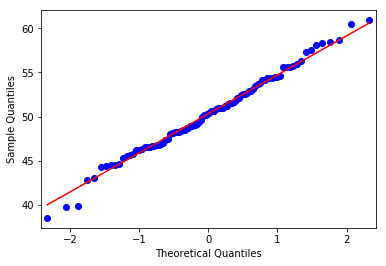

In [40]:
# QQ Plot in theory
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# q-q plot
qqplot(data, line='s')
pyplot.show()

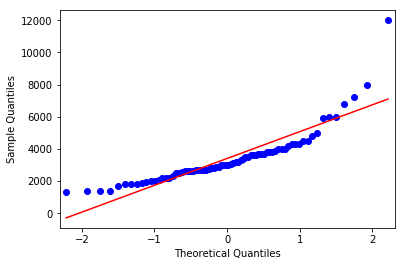

In [42]:
qqplot(to_rooms.Price, line='s')
pyplot.show()

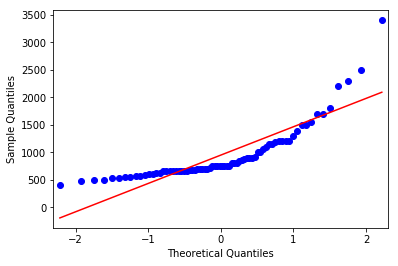

In [43]:
qqplot(to_rooms.Sqft, line='s')
pyplot.show()

In [44]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.992, p=0.822
Sample looks Gaussian (fail to reject H0)


In [46]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# normality test
stat, p = shapiro(to_rooms.Price)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.803, p=0.000
Sample does not look Gaussian (reject H0)


- Not a normal distribution 

In [47]:
# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# normality test
stat, p = shapiro(to_rooms.Sqft)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.746, p=0.000
Sample does not look Gaussian (reject H0)


- Not a normal distribution 

In [48]:
#Parametric test
to_rooms.corr(method ='pearson') 

,Price,Sqft,Bedrooms
Price,1.000000,0.689492,0.681352
Sqft,0.689492,1.000000,0.879261
Bedrooms,0.681352,0.879261,1.000000


In [49]:
#Non paramatric test
to_rooms.corr(method ='kendall') 

,Price,Sqft,Bedrooms
Price,1.000000,0.466594,0.464213
Sqft,0.466594,1.000000,0.698434
Bedrooms,0.464213,0.698434,1.000000


In [51]:
to_rooms.head()

,Date_Posted,Neighborhood,Post_Title,URL,Price,Sqft,Bedrooms
0,2019-09-17 18:24:00,toronto,house for lease,https://toronto.craigslist.org/tor/apa/d/north...,4800,2500.0,3.0
1,2019-09-17 18:10:00,Danforth East @ Main St,One Bedroom Condo (+ Den) for Rent on the Danf...,https://toronto.craigslist.org/tor/apa/d/toron...,1900,618.0,1.0
3,2019-09-17 18:03:00,Etobicoke,Fully Furnished 1bd + 1 den short term rental ...,https://toronto.craigslist.org/tor/apa/d/etobi...,2650,675.0,1.0
4,2019-09-17 17:47:00,50 Lombard St,Newly Renovated South Facing Condo Unit @ Lomb...,https://toronto.craigslist.org/tor/apa/d/toron...,2750,750.0,1.0
5,2019-09-17 17:44:00,Scarborough,3 Level 2 Bedroom 3 Bathroom Home with Large P...,https://toronto.craigslist.org/tor/apa/d/scarb...,2995,1700.0,2.0


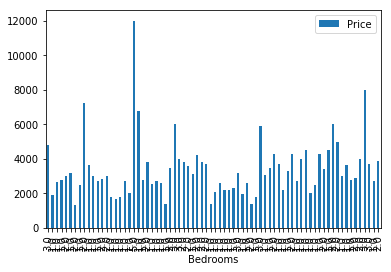

In [52]:
to_rooms.plot.bar(x='Bedrooms', y='Price')

In [53]:
to_rooms.groupby('Bedrooms')

In [54]:
to_rooms.groupby('Bedrooms')['Price'].sum()

Bedrooms
1.0    125788
2.0     78949
3.0     35589
5.0     12000
Name: Price, dtype: int64

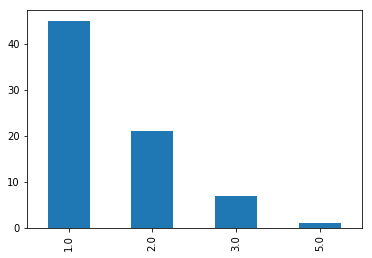

In [55]:
to_rooms['Bedrooms'].value_counts().plot(kind='bar')

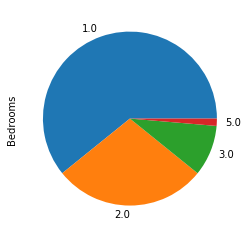

In [56]:
to_rooms['Bedrooms'].value_counts().plot(kind='pie')

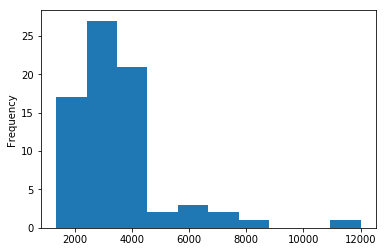

In [57]:
to_rooms['Price'].plot(kind='hist')

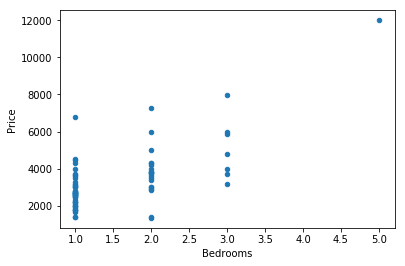

In [58]:
to_rooms[['Bedrooms', 'Price']].plot(x='Bedrooms', y='Price', kind='scatter')

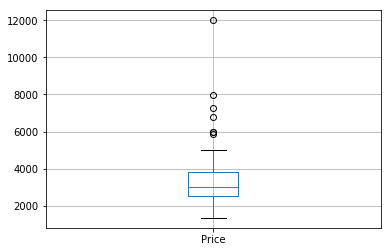

In [59]:
to_rooms.boxplot("Price")

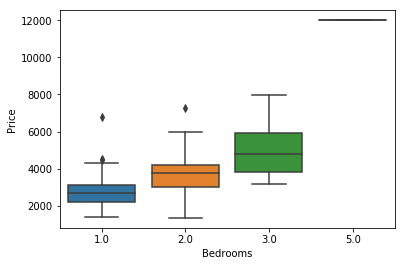

In [60]:
sns.boxplot(x='Bedrooms', y='Price', data = to_rooms)


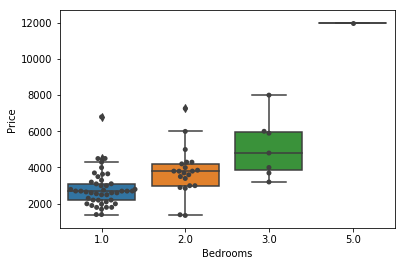

In [61]:
sns.boxplot(x='Bedrooms', y='Price', data = to_rooms)
sns.swarmplot(x='Bedrooms', y='Price', data = to_rooms, color=".25")

Text(0, 0.5, 'Square Feet')

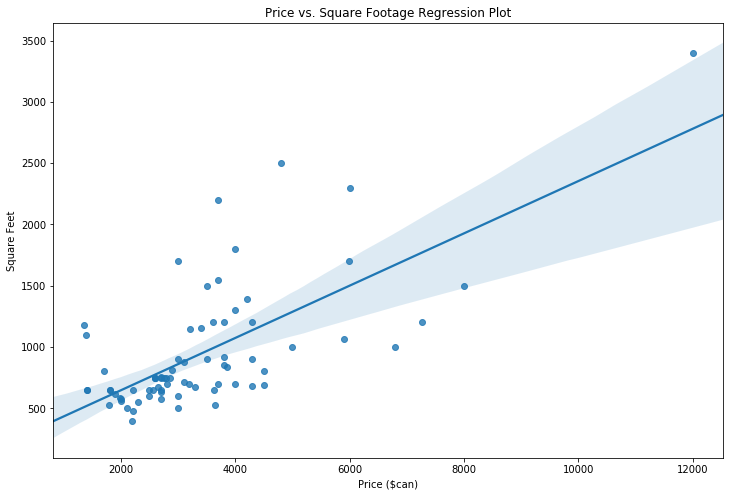

In [63]:
plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Sqft', data=to_rooms);
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price ($can)")
plt.ylabel("Square Feet")

In [64]:
to_rooms.describe()

,Price,Sqft,Bedrooms
count,74.000000,74.000000,74.000000
mean,3409.810811,948.310811,1.527027
std,1678.525737,519.029941,0.780287
min,1350.000000,400.000000,1.000000
25%,2508.750000,650.000000,1.000000
50%,2995.000000,750.000000,1.000000
75%,3837.500000,1137.500000,2.000000
max,12000.000000,3400.000000,5.000000
